In [101]:
import jcamp
import os
from glob import glob

MIN_WAVENUMBER = 400
MAX_WAVENUMBER = 4000
COVER_THRESHOLD = 0.25

error_reasons = [0, 0, 0, 0, 0]

def is_jdx_valid(jdx_file):
    # If a jdx file can't be read by the jcamp library we just consider it invalid
    try:
        jcamp_dict = jcamp.jcamp_readfile(jdx_file)
    except Exception as e:
        error_reasons[0] = error_reasons[0] + 1
        return False, {}
    
    # Some jcamp files contain a full spectrum and peak tables/other data. In these cases the jcamp_dict['children'] exists.
    # We only care about the full spectrum so we ignore the peak tables/other data. The full spectrum is always the first child.
    if ('children' in jcamp_dict):
        jcamp_dict = jcamp_dict['children'][0]
    
    # Some very old spectra don't have jdx files yet NIST provides downloads for them anyway.
    # These files don't have any measurements and sometimes don't even include the npoints tag so we filter them out.
    if ((not 'npoints' in jcamp_dict) or jcamp_dict['npoints'] < 1):
        error_reasons[1] = error_reasons[1] + 1
        return False, jcamp_dict
    
    # Some spectra use y units like absorption/refraction index as their y units.
    # These can't be easily converted to absorbance/transmittance and the jcamp library parses them wrong so we filter them out.
    if (jcamp_dict['yunits'].lower() != 'transmittance' and jcamp_dict['yunits'].lower() != 'absorbance'):
        error_reasons[2] = error_reasons[2] + 1
        return False, jcamp_dict
    
    if (not 'xunits' in jcamp_dict):
        error_reasons[3] = error_reasons[3] + 1
        return False, jcamp_dict
    
    # We first have to make sure our first/last x are given in cm^-1
    if ('minx' in jcamp_dict):
        min_x = jcamp_dict['minx']
    else:
        min_x = min(jcamp_dict['x'])
        
    if ('maxx' in jcamp_dict):
        max_x = jcamp_dict['maxx']
    else:
        max_x = max(jcamp_dict['x'])

    if (jcamp_dict['xunits'].lower() == 'micrometers'):
        min_x = 1e4 / min_x
        max_x = 1e4 / max_x
        
    # Since we only care for the spectrum from wavenumbers MIN_WAVENUMBER to MAX_WAVENUMBER, we disregard any coverage outside that range.
    min_x = max(min_x, MIN_WAVENUMBER)
    max_x = min(max_x, MAX_WAVENUMBER)
    
    # Some samples only cover a very small range of wavelengths. This is generally bad so we filter them out.
    cover = (max_x - min_x) / (MAX_WAVENUMBER - MIN_WAVENUMBER)
    if (cover < COVER_THRESHOLD):
        error_reasons[4] = error_reasons[4] + 1
        return False, jcamp_dict
    
    return True, jcamp_dict

In [102]:
from rdkit import Chem
import re

# SMARTS taken from Jung, G. et al (https://github.com/gj475/irchracterizationcnn/blob/main/scripts/smarts.py)
functional_group_patterns = {
    #'group_name': Chem.MolFromSmarts['smarts_code']
    'alkane': Chem.MolFromSmarts('[CX4;H3,H2]'),
    'alkene': Chem.MolFromSmarts('[CX3]=[CX3]'),
    'alkyne': Chem.MolFromSmarts('[CX2]#[CX2]'),
    'arene': Chem.MolFromSmarts('[cX3]1[cX3][cX3][cX3][cX3][cX3]1'),
    'haloalkane': Chem.MolFromSmarts('[#6][F,Cl,Br,I]'),
    'alcohol': Chem.MolFromSmarts('[#6][OX2H]'),
    'aldehyde': Chem.MolFromSmarts('[CX3H1](=O)[#6,H]'),
    'ketone': Chem.MolFromSmarts('[#6][CX3](=O)[#6]'),
    'carboxylic_acid': Chem.MolFromSmarts('[CX3](=O)[OX2H]'),
    'acid_anhydride': Chem.MolFromSmarts('[CX3](=[OX1])[OX2][CX3](=[OX1])'),
    'acyl_halide': Chem.MolFromSmarts('[CX3](=[OX1])[F,Cl,Br,I]'),
    'ester': Chem.MolFromSmarts('[#6][CX3](=O)[OX2H0][#6]'),
    'ether': Chem.MolFromSmarts('[OD2]([#6])[#6]'),
    'amine': Chem.MolFromSmarts('[NX3;H2,H1,H0;!$(NC=O)]'),
    'amide': Chem.MolFromSmarts('[NX3][CX3](=[OX1])[#6]'),
    'nitrile': Chem.MolFromSmarts('[NX1]#[CX2]'),
    'imide': Chem.MolFromSmarts('[CX3](=[OX1])[NX3][CX3](=[OX1])'),
    'imine': Chem.MolFromSmarts('[$([CX3]([#6])[#6]),$([CX3H][#6])]=[$([NX2][#6]),$([NX2H])]'),
    'azo_compound': Chem.MolFromSmarts('[#6][NX2]=[NX2][#6]'),
    'thiol': Chem.MolFromSmarts('[#16X2H]'),
    'thial': Chem.MolFromSmarts('[CX3H1](=O)[#6,H]'),
    'sulfone': Chem.MolFromSmarts('[#16X4](=[OX1])(=[OX1])([#6])[#6]'),
    'sulfonic_acid': Chem.MolFromSmarts('[#16X4](=[OX1])(=[OX1])([#6])[OX2H]'),
    'enol': Chem.MolFromSmarts('[OX2H][#6X3]=[#6]'),
    'phenol': Chem.MolFromSmarts('[OX2H][cX3]:[c]'),
    'hydrazine': Chem.MolFromSmarts('[NX3][NX3]'),
    'enamine': Chem.MolFromSmarts('[NX3][CX3]=[CX3]'),
    'isocyanate': Chem.MolFromSmarts('[NX2]=[C]=[O]'),
    'isothiocyanate': Chem.MolFromSmarts('[NX2]=[C]=[S]'),
    'phosphine': Chem.MolFromSmarts('[PX3]'),
    'sulfonamide': Chem.MolFromSmarts('[#16X4]([NX3])(=[OX1])(=[OX1])[#6]'),
    'sulfonate': Chem.MolFromSmarts('[#16X4](=[OX1])(=[OX1])([#6])[OX2H0]'),
    'sulfoxide': Chem.MolFromSmarts('[#16X3]=[OX1]'),
    'thioamide': Chem.MolFromSmarts('[NX3][CX3]=[SX1]'),
    'hydrazone': Chem.MolFromSmarts('[NX3][NX2]=[#6]'),
    'carbamate': Chem.MolFromSmarts('[NX3][CX3](=[OX1])[OX2H0]'),
    'sulfide': Chem.MolFromSmarts('[#16X2H0]')
}

# Finds functional groups, given a mol object (use one of the methods below instead of this one)
def find_functional_groups_from_mol(mol):
    if mol is None:
        return []
    
    functional_groups = []
    for functional_group in functional_group_patterns:
        if mol.HasSubstructMatch(functional_group_patterns[functional_group]):
            functional_groups.append(functional_group)
    return functional_groups

# Finds functional groups, given a path to a .mol file
def find_functional_groups_mol(mol_path):
    mol = Chem.MolFromMolFile(mol_path)
    return find_functional_groups_from_mol(mol)

# Finds functional groups, given some smiles code
def find_functional_groups_smiles(smiles_code):
    mol = Chem.MolFromSmiles(smiles_code)
    return find_functional_groups_from_mol(mol)


def get_state_from_jdx(jcamp_dict):
    if 'state' in jcamp_dict:
        state_raw = jcamp_dict['state']
        state = state_raw.strip().lower()
        return re.split(r"[;, ()]+", state)[0]
    else:
        return 'not specified'


state_counts = {}
functional_groups_samples_counts = {}
functional_groups_molecules_counts = {}
number_of_groups_samples_counts = {}
number_of_groups_molecules_counts = {}

def increase_counter(counting_dict, key, amount):
    if key in counting_dict:
        counting_dict[key] = counting_dict[key] + amount
    else:
        counting_dict[key] = amount

In [103]:
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
import json

def preprocess_jdx(jcamp_dict, baseline_correct=True):  
    yvals_raw = jcamp_dict['y']
    yunits = jcamp_dict['yunits'].lower()
    
    xvals_raw = jcamp_dict['x']
    xunits = jcamp_dict['xunits'].lower()
    
    if (xunits == 'micrometers'):
        # wavenumber = 10^4 / wavelength
        xvals_raw = 1e4 / xvals_raw 
        
    # Convert all y values to absorbance
    if (yunits == 'transmittance'):
        yvals_raw = -np.log10(np.clip(yvals_raw, 1e-8, None))
        
    if baseline_correct:
        yvals_raw = yvals_raw - np.min(yvals_raw)
    
    # We fill missing values with zeroes
    interpolator = interp1d(xvals_raw, yvals_raw, kind='linear', fill_value=0, bounds_error=False)
    xvals_new = np.linspace(MIN_WAVENUMBER, MAX_WAVENUMBER, MAX_WAVENUMBER - MIN_WAVENUMBER)
    yvals_new = interpolator(xvals_new)
    
    max_y = np.max(yvals_new)
    if max_y > 0:
        yvals_new = yvals_new / max_y
      
    #plt.plot(xvals_new, yvals_new, '.', label='Interpolated data')
    #plt.plot(xvals_raw, yvals_raw, '.', label='Raw data')
    #plt.legend()
    #plt.show()
    
    return yvals_new

absorbances_list = []
labels_list = []

In [104]:
# PREPROCESSING FOR NIST DATA
NIST_MOL_FOLDER = 'data\\NIST\\mol'
NIST_JDX_FOLDER = 'data\\NIST\\jdx'

mol_files = glob(os.path.join(NIST_MOL_FOLDER, '*.mol'))
jdx_files = glob(os.path.join(NIST_JDX_FOLDER, '*.jdx'))

jdx_cas_to_jdx_path = {}
for jdx_path in jdx_files:
    jdx_cas_with_index = os.path.splitext(os.path.basename(jdx_path))[0]
    jdx_cas_to_jdx_path[jdx_cas_with_index] = os.path.abspath(jdx_path)
    
mol_to_jdx = {}

# Find out which .jdx files belong to which .mol files
for mol_path in mol_files:
    mol_cas = os.path.splitext(os.path.basename(mol_path))[0]
    matching_jdx = []
    
    index = 0
    while (True):
        cas_with_index = mol_cas + ("-IR-%i" % (index))
        if cas_with_index in jdx_cas_to_jdx_path:
            matching_jdx.append(jdx_cas_to_jdx_path[cas_with_index])
            index = index + 1
        else:
            break
    
    mol_to_jdx[os.path.abspath(mol_path)] = matching_jdx

# Preprocess NIST data and gather information about the data
initial_spectrum_count = 0
final_spectrum_count = 0
molecule_count = 0
NIST_spectrum_count = 0
chemotion_spectrum_count = 0

for mol_file, jdx_list in mol_to_jdx.items():
    initial_spectrum_count = initial_spectrum_count + len(jdx_list)
    jdx_list = mol_to_jdx[mol_file]

    number_of_valid_jdx = 0
    # Preprocess all jdx files that pass the tests in is_jdx_valid
    for jdx_file in jdx_list:
        valid, jcamp_dict = is_jdx_valid(jdx_file)
        if (not valid):
            continue

        increase_counter(state_counts, get_state_from_jdx(jcamp_dict), 1)
        absorbances_list.append(preprocess_jdx(jcamp_dict))
        number_of_valid_jdx = number_of_valid_jdx + 1
    
    # In case there are valid jdx files, gather data about functional groups for graphs
    if (number_of_valid_jdx > 0):
        molecule_count = molecule_count + 1
        functional_groups = find_functional_groups_mol(mol_file)
        for i in range(number_of_valid_jdx):
            labels_list.append(functional_groups)

        for functional_group in functional_groups:
            increase_counter(functional_groups_samples_counts, functional_group, number_of_valid_jdx)
            increase_counter(functional_groups_molecules_counts, functional_group, 1)
        increase_counter(number_of_groups_samples_counts, str(len(functional_groups)), number_of_valid_jdx)
        increase_counter(number_of_groups_molecules_counts, str(len(functional_groups)), 1)
    final_spectrum_count = final_spectrum_count + number_of_valid_jdx

NIST_spectrum_count = final_spectrum_count

In [105]:
# PREPROCESSING FOR CHEMOTION DATA

CHEMOTION_JDX_FOLDER = 'data\\Chemotion\\jdx'
CHEMOTION_JDX_META = 'data\\Chemotion\\meta_data.json'

with open(CHEMOTION_JDX_META, 'r') as file:
    metadata = json.load(file)

# Preprocessing for chemotion data is very similar to preprocessing for NIST data, we just need to use the metadata file
# to find the right jcamp dx spectra.
for i in range(len(metadata)):
    samples = metadata[i]['datasets'][0]['attacments']
    
    number_of_valid_jdx = 0
    initial_spectrum_count = initial_spectrum_count + len(samples)
    for j in range(len(samples)):
        identifier = samples[j]['identifier']
        # The identifiers are structured like this: n / jdx_file_name. We are only interested in the file name.
        jdx_file_name = identifier.split('/')[-1]
        
        jdx_path = '%s\\%s' % (CHEMOTION_JDX_FOLDER, jdx_file_name)
        valid, jcamp_dict = is_jdx_valid(jdx_path)
        if (not valid):
            continue
            
        increase_counter(state_counts, get_state_from_jdx(jcamp_dict), 1)
        absorbances_list.append(preprocess_jdx(jcamp_dict))
        number_of_valid_jdx = number_of_valid_jdx + 1
    
    if (number_of_valid_jdx > 0):
        molecule_count = molecule_count + 1
        # Chemotion doesn't provide .mol files, only canonical smiles codes
        functional_groups = find_functional_groups_smiles(metadata[i]['cano_smiles'])
        for i in range(number_of_valid_jdx):
            labels_list.append(functional_groups)

        for functional_group in functional_groups:
            increase_counter(functional_groups_samples_counts, functional_group, number_of_valid_jdx)
            increase_counter(functional_groups_molecules_counts, functional_group, 1)
        increase_counter(number_of_groups_samples_counts, str(len(functional_groups)), number_of_valid_jdx)
        increase_counter(number_of_groups_molecules_counts, str(len(functional_groups)), 1)
    final_spectrum_count = final_spectrum_count + number_of_valid_jdx

chemotion_spectrum_count = final_spectrum_count - NIST_spectrum_count
    

In [106]:
print('Reduced from %i .jdx files to %i .jdx files' % (initial_spectrum_count, final_spectrum_count))
print('Of the %i spectra that were removed, %i could not be read, %i did not have any datapoints, %i had wrong/unclear units, %i lacked vital metadata and %i lacked coverage' % (initial_spectrum_count - final_spectrum_count, error_reasons[0], error_reasons[1], error_reasons[2], error_reasons[3], error_reasons[4]))
print('Currently there are %i .jdx files corresponding to %i .mol files' % (final_spectrum_count, molecule_count))
print('Of the %i spectra, %i came from NIST and %i came from Chemotion' % (final_spectrum_count, NIST_spectrum_count, chemotion_spectrum_count))

Reduced from 19626 .jdx files to 15615 .jdx files
Of the 4011 spectra that were removed, 1 could not be read, 667 did not have any datapoints, 929 had wrong/unclear units, 0 lacked vital metadata and 2414 lacked coverage
Currently there are 15615 .jdx files corresponding to 12301 .mol files
Of the 15615 spectra, 11436 came from NIST and 4179 came from Chemotion


In [107]:
print('Distribution of functional groups in the dataset:')
for label, count in functional_groups_samples_counts.items():
    print('| %s: %i samples (%f%% of total)' % (label, count, (count / final_spectrum_count) * 100.0))

Distribution of functional groups in the dataset:
| arene: 9053 samples (57.976305% of total)
| haloalkane: 4115 samples (26.352866% of total)
| amine: 3352 samples (21.466539% of total)
| alcohol: 2848 samples (18.238873% of total)
| phenol: 711 samples (4.553314% of total)
| alkane: 12357 samples (79.135447% of total)
| ketone: 1439 samples (9.215498% of total)
| ether: 4050 samples (25.936599% of total)
| aldehyde: 443 samples (2.837016% of total)
| thial: 443 samples (2.837016% of total)
| alkene: 2138 samples (13.691963% of total)
| nitrile: 643 samples (4.117835% of total)
| thiol: 159 samples (1.018252% of total)
| hydrazine: 120 samples (0.768492% of total)
| carbamate: 144 samples (0.922190% of total)
| amide: 1269 samples (8.126801% of total)
| alkyne: 508 samples (3.253282% of total)
| carboxylic_acid: 838 samples (5.366635% of total)
| hydrazone: 48 samples (0.307397% of total)
| sulfide: 842 samples (5.392251% of total)
| ester: 1977 samples (12.660903% of total)
| phosphi

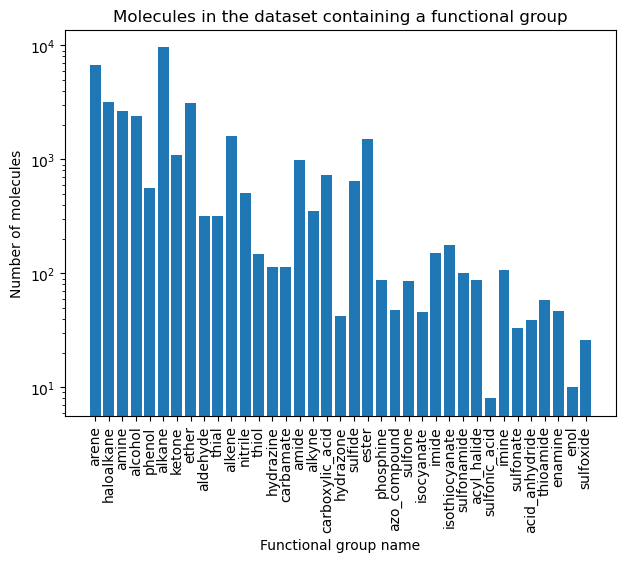

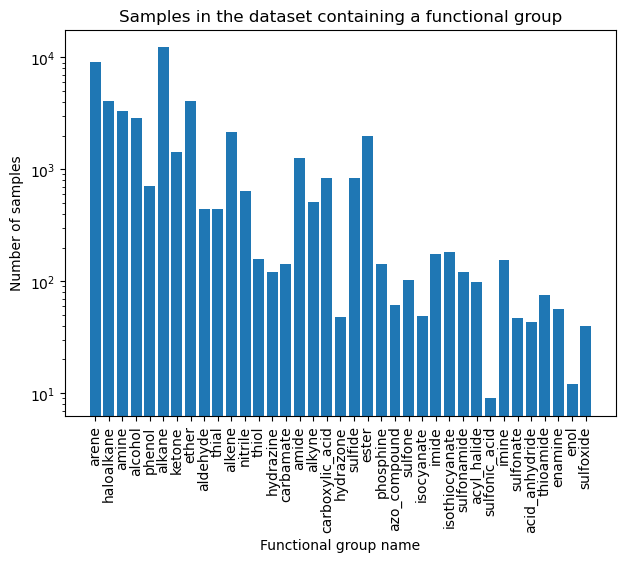

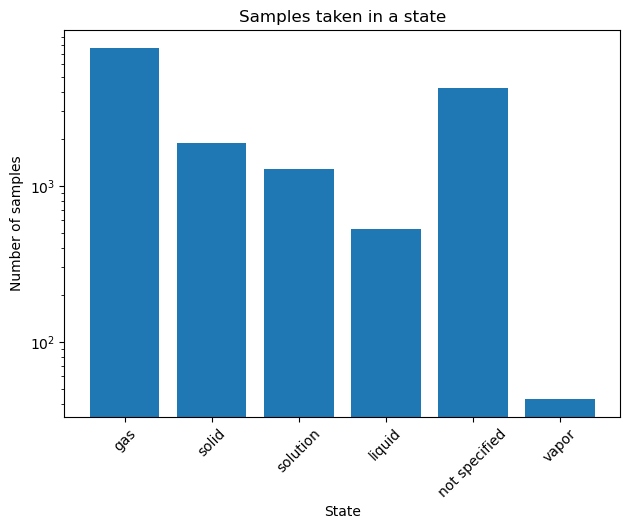

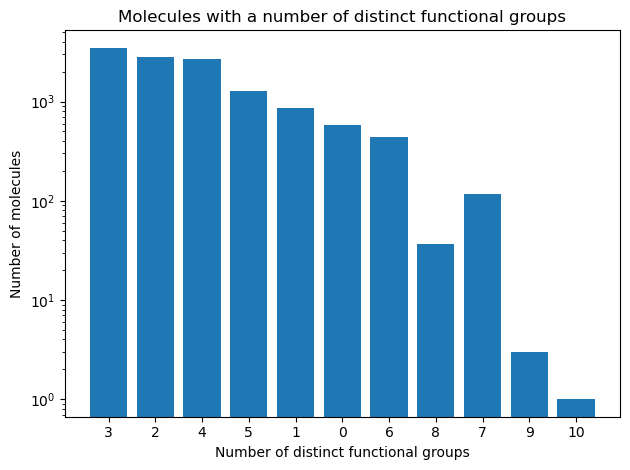

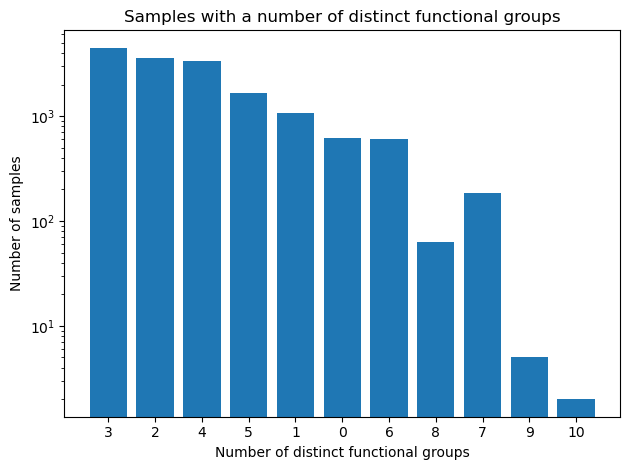

In [108]:
import matplotlib.pyplot as plt

# Used to prevent states with only a few samples from cluttering the state graph 
DISPLAY_THRESHOLD = 20
# CHANGE THIS TO THE FOLDER WHERE YOU WANT TO SAVE THE GRAPHS
PLT_PATH = 'plot_images'

# FUNCTIONAL GROUP COUNTS MOLECULES
group_names_mol = list(functional_groups_molecules_counts.keys())
group_counts_mol = list(functional_groups_molecules_counts.values())

plt.bar(group_names_mol, group_counts_mol)
plt.xlabel('Functional group name')
plt.ylabel('Number of molecules')
plt.yscale('log')
plt.title('Molecules in the dataset containing a functional group')
plt.tight_layout()
plt.xticks(rotation=90)

plt_path = os.path.join(PLT_PATH, 'functional_groups_mol.png')
#bbox_inches is needed to prevent some of the labels from getting cropped out
plt.savefig(plt_path, bbox_inches='tight')
plt.show()

# FUNCTIONAL GROUP COUNTS SAMPLES/SPECTRA
group_names_samples = list(functional_groups_samples_counts.keys())
group_counts_samples = list(functional_groups_samples_counts.values())

plt.bar(group_names_samples, group_counts_samples)
plt.xlabel('Functional group name')
plt.ylabel('Number of samples')
plt.yscale('log')
plt.title('Samples in the dataset containing a functional group')
plt.tight_layout()
plt.xticks(rotation=90)

plt_path = os.path.join(PLT_PATH, 'functional_groups_sample.png')
plt.savefig(plt_path, bbox_inches='tight')
plt.show()

# SAMPLE/SPECTRUM STATES
state_names = [state for state in list(state_counts.keys()) if state_counts[state] >= DISPLAY_THRESHOLD]
state_counts_tot = [count for count in list(state_counts.values()) if count >= DISPLAY_THRESHOLD]
plt.bar(state_names, state_counts_tot)
plt.xlabel('State')
plt.ylabel('Number of samples')
plt.yscale('log')
plt.title('Samples taken in a state')
plt.tight_layout()
plt.xticks(rotation=45)

plt_path = os.path.join(PLT_PATH, 'states.png')
plt.savefig(plt_path, bbox_inches='tight')
plt.show()

# NUMBER OF MOLECULES WITH SOME NUMBER OF UNIQUE FUNCTIONAL GROUPS
group_counts_nos_molecules = list(number_of_groups_molecules_counts.keys())
group_counts_molecules = list(number_of_groups_molecules_counts.values())

plt.bar(group_counts_nos_molecules, group_counts_molecules)
plt.xlabel('Number of distinct functional groups')
plt.ylabel('Number of molecules')
plt.yscale('log')
plt.title('Molecules with a number of distinct functional groups')
plt.tight_layout()

plt_path = os.path.join(PLT_PATH, 'number_of_groups_mol.png')
plt.savefig(plt_path, bbox_inches='tight')
plt.show()

# NUMBER OF SAMPLES WITH SOME NUMBER OF UNIQUE FUNCTIONAL GROUPS
group_counts_nos_samples = list(number_of_groups_samples_counts.keys())
group_counts_samples = list(number_of_groups_samples_counts.values())

plt.bar(group_counts_nos_samples, group_counts_samples)
plt.xlabel('Number of distinct functional groups')
plt.ylabel('Number of samples')
plt.yscale('log')
plt.title('Samples with a number of distinct functional groups')
plt.tight_layout()

plt_path = os.path.join(PLT_PATH, 'number_of_groups_sample.png')
plt.savefig(plt_path, bbox_inches='tight')
plt.show()

In [109]:
CSV_PATH = 'spectra.csv'

# We need to convert to json first, if we don't then the spectrum will get shortened to something like
# [0.0, 0.0, ... 0,0] and we will lose the majority of our data.
df = pd.DataFrame({'spectrum': [json.dumps(spectrum.tolist()) for spectrum in absorbances_list], 
                   'labels': [json.dumps(label_list) for label_list in labels_list]})

# KEEP THIS COMMENTED IF YOU DONT WANT TO WRITE THE CSV
#df.to_csv(CSV_PATH, index=False)